In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import geoutils as gu
from adjustText import adjust_text

In [14]:
import sys
!{sys.executable} -m pip install bokeh

  Obtaining dependency information for bokeh from https://files.pythonhosted.org/packages/c6/5d/46cde55344ad96a0570e2f72d9df428349a6a800448f6a5b6140c337f930/bokeh-3.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for xyzservices>=2021.09.1 from https://files.pythonhosted.org/packages/50/d7/2ca7f65c189aa71b5a9dfeaabc0b4ab8d50bead74a7863428c579737d625/xyzservices-2023.7.0-py3-none-any.whl.metadata
Using cached bokeh-3.2.1-py3-none-any.whl (7.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 765.7 kB/s eta 0:00:001m1.7 MB/s eta 0:00:01


In [7]:
# Load Shapefile, CSV and DEM data
him = gpd.read_file("shpfiles/him_region.gpkg")
hma = gpd.read_file("shpfiles/boundary_mountain_regions_hma_v3_clean.gpkg")
basin_feature = gpd.read_file("shpfiles/igb_basins_final.gpkg")
hma_basin_feature = gpd.read_file("shpfiles/hma_river_basins.gpkg")

glac_points = pd.read_csv("csv_files/glacier_locations.csv")
gdf_glac_points = gpd.GeoDataFrame(glac_points, geometry=gpd.points_from_xy(glac_points['X'], glac_points['Y']))

smbs = pd.read_csv("csv_files/MB_all_glaciers.csv")
smbs = pd.DataFrame(smbs).set_index('Year')
# wide to long format
smbs = smbs.reset_index().melt(id_vars='Year', var_name='Glacier', value_name='Value')
smbs.set_index('Year', inplace=True)

#climate_era5_csv = "path/to/climate_era5_records.csv"
dem = gu.Raster('dem/hma_dem_1km.tif')

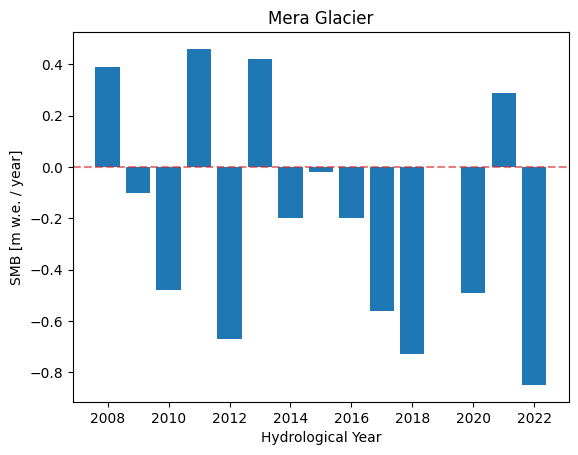

In [8]:
glacier = 'Mera'

ex_df = smbs[smbs.Glacier == glacier]
point_df = glac_points[glac_points.Glaciers == glacier]
plt.bar(ex_df.index, ex_df.Value)
plt.axhline(y=0, linestyle='--', color='tab:red', alpha=0.6)
plt.ylabel('SMB [m w.e. / year]')
plt.xlabel('Hydrological Year')
plt.title(glacier + ' Glacier')
plt.show()

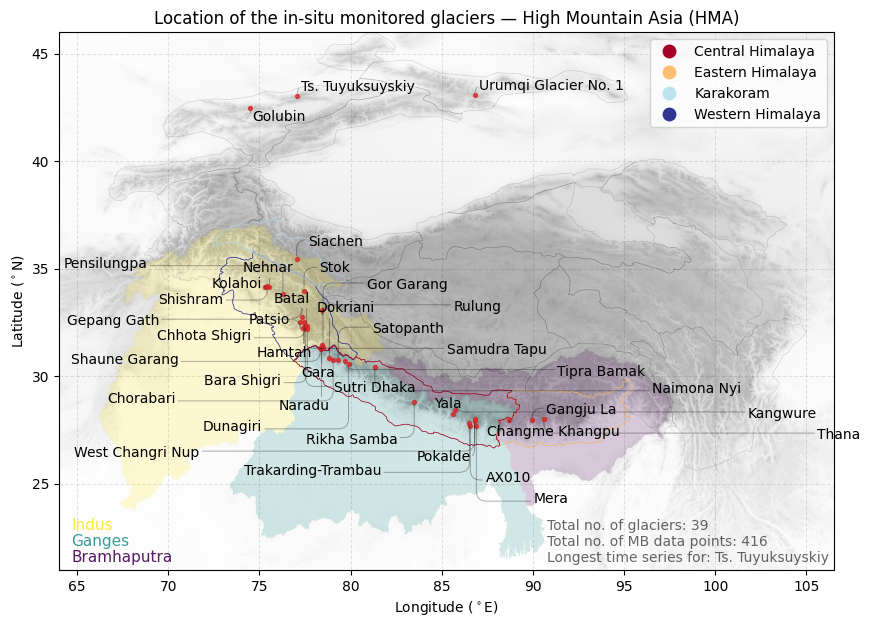

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# Figure components
dem.show(ax=ax, cmap='Greys', add_cbar=False, alpha=0.6)
basin_feature.plot(ax=ax, alpha = 0.2, column='L1_Name', legend=False, categorical=True, cmap='viridis')
#hma_basin_feature.plot(ax=ax, alpha = 0.2, column='L1_Name', legend=True, categorical=True, cmap='viridis')
hma.plot(ax=ax, column='himap_region', legend=False, facecolor='none', alpha=0.15, edgecolor='k', linewidth=0.5,
        legend_kwds={'fontsize': 7.5, 'markerscale': 0.5, 'framealpha': 0.4, 'edgecolor':'grey'})
him.plot(ax=ax, column='himap_regi', legend=True, facecolor='none', cmap='RdYlBu', linewidth=0.5)
ax.scatter(glac_points.X, glac_points.Y, alpha=0.8, c='tab:red', s=8)


# legend.get_frame().set_alpha(0.7)
# legend._legend_box.align = "left"
# legend.get_title().set_fontsize('9')


# Labels
texts = []
for i in range(len(glac_points)):
    x = glac_points.X[i]
    y = glac_points.Y[i]
    label = glac_points['Glaciers'][i]
    #ax.text(x, y, label, fontsize=10, va='center', ha='left')
    texts.append(plt.text(x, y, label, size=10))

adjust_text(texts, arrowprops=dict(arrowstyle="-", alpha=0.3, color='k', lw=0.75, connectionstyle="angle,angleA=0,angleB=90,rad=10")) # arc3,rad=.1

# Styling
plt.ylim(21, 46)
plt.xlim(64, 106.5)
ax.set_title('Location of the in-situ monitored glaciers — High Mountain Asia (HMA)', size=12) # fontweight="bold"
plt.xlabel('Longitude ($^\circ$E)')
plt.ylabel('Latitude ($^\circ$N)')
ax.grid(alpha=0.1, color='k', linestyle='--', linewidth=0.75)

ax.text(64.7, 22.85, 'Indus', color='#fde725', size=11, alpha=0.9)
ax.text(64.7, 22.1, 'Ganges', color='#21918c', size=11, alpha=0.9)
ax.text(64.7, 21.35, 'Bramhaputra', color='#440154', size=11, alpha=0.9)

ax.text(90.75, 22.85, 'Total no. of glaciers: '+ str(glac_points.count()[0]), color='k', size=10, alpha=0.6)
ax.text(90.75, 22.1, 'Total no. of MB data points: '+ str(smbs.Value.count()), color='k', size=10, alpha=0.6)
ax.text(90.75, 21.35, 'Longest time series for: Ts. Tuyuksuyskiy', color='k', size=10, alpha=0.6)

# Save
plt.savefig("HMA_GMB_Tracker.jpg", dpi=300, bbox_inches ="tight")
plt.show()

# Interactive vBar Plot

In [16]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, CustomJS, Select, HoverTool, Label
from bokeh.layouts import column, row

# Example glacier_names based on your data files
glacier_names = glac_points['Glaciers'].unique().tolist()

# Get the year range from the smbs DataFrame index
year_range = smbs.index.unique().tolist()

# Add the 'Glacier' column back to the 'glac_points' DataFrame
glac_points['Glacier'] = glacier_names

# Create a DataFrame for time series data with the year range as the index
time_series_data = pd.DataFrame(index=year_range)

# Fill the DataFrame with mass balance data for each glacier
for glacier in glacier_names:
    ex_df = smbs[smbs['Glacier'] == glacier]
    smb_values = ex_df['Value']
    time_series_data[f'SMB_{glacier}'] = smb_values

# Create a ColumnDataSource for Bokeh
source = ColumnDataSource(time_series_data)

# Create a Bokeh figure
p = figure(title='Surface Mass Balance Time Series', x_axis_label='Year', y_axis_label='Glacier-wide mass balance (m w.e. / year)')

# Create bars for each glacier and store them in a dictionary
bars = {}
bar_width = 0.8
for i, glacier in enumerate(glacier_names):
    y = f'SMB_{glacier}'
    bars[glacier] = p.vbar(x='index', top=y, source=source, width=bar_width,
                           color=f'#{(i+1):02x}{(i+1):02x}{(i+1):02x}', alpha=0.7, visible=False) 

# Set the initial selected glacier
selected_glacier = glacier_names[0]
bars[selected_glacier].visible = True

# Create the dropdown widget
dropdown = Select(title='Select Glacier:', value=selected_glacier, options=glacier_names)

# Define the callback function for the dropdown widget
callback = CustomJS(args=dict(source=source, bars=bars, p=p, dropdown=dropdown, glac_points=glac_points.to_dict(orient='list')), code="""
    const data = source.data;
    const selected_glacier = dropdown.value;
    const legend_items = [];
    for (const [glacier, bar] of Object.entries(bars)) {
        const y = data[`SMB_${glacier}`];
        if (glacier === selected_glacier) {
            bar.visible = true;
            bar.data_source.data['index'] = data['index'];
            bar.data_source.data['top'] = y;
            legend_items.push(bar); // Add the selected glacier to the legend
            // Update the label's text and position
            const mytext = bar.glyph.label;
            mytext.text = selected_glacier;
            mytext.y = Math.max(...y); // Position the label at the top of the bar
        } else {
            bar.visible = false;
            // Set y-values to 0 for non-selected glaciers to hide their bars
            bar.data_source.data['top'] = Array(y.length).fill(0);
        }
    }
    p.legend.items = legend_items; // Update the legend with the selected glacier
    p.legend.click_policy = "hide"; // Hide/show legends on click

    // Update the plot title with the selected glacier name and region
    const region = glac_points['Himalaya'][glacier_names.indexOf(selected_glacier)];
    p.title.text = `Surface Mass Balance Time Series for the ${selected_glacier}, ${region}`;
    
    source.change.emit();
""")

# Attach the callback to the dropdown's value attribute
dropdown.js_on_change('value', callback)

# Layout the widgets and plot
layout = column(dropdown, p)

# Output the plot to a file
output_file("smb_time_series.html")
show(layout)